## GGD Case intensity prediction - Part 2 (Evaluation)

#### Notebook structure:
1. Import modules
2. Import data
3. Load tuned models
4. Test predictions
5. Out-of-sample predictions


### 1. Import modules

In [1]:
# Global
import pandas as pd
import numpy as np
from data_preprocessors.target_creation import *
import pyodbc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ML
from sklearn.linear_model import Ridge

# FFNN
from keras.models import load_model

# Model selection
import shap
import joblib
from sklearn.inspection import permutation_importance
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error, r2_score, make_scorer

### 2. Import data

In [2]:
# load X's from Data\Splits
X_test_featurized = pd.read_pickle('..\\..\\Data\\Splits\\20240502_X_test_featurized.pkl')
X_oos_featurized = pd.read_pickle('..\\..\\Data\\Splits\\20240502_X_oos_featurized.pkl')
X_test_censored_featurized = pd.read_pickle('..\\..\\Data\\Splits\\20240502_X_test_censored_featurized.pkl')
X_oos_censored_featurized = pd.read_pickle('..\\..\\Data\\Splits\\20240502_X_oos_censored_featurized.pkl')

# load y's from Data\Splits (log)
y_test_log = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_test_log.pkl')
y_oos_log = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_oos_log.pkl')
y_test_censored_log = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_test_censored_log.pkl')
y_oos_censored_log = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_oos_censored_log.pkl')

# load y's from Data\Splits
y_test = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_test.pkl')
y_oos = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_oos.pkl')
y_test_censored = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_test_censored.pkl')
y_oos_censored = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_oos_censored.pkl')

# load combined splits from Data\Splits
y_train_val_balanced_log = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_train_val_balanced_log.pkl')
y_train_val_log = pd.read_pickle('..\\..\\Data\\Splits\\20240502_y_train_val_log.pkl')

# load combined splits from Data\Splits
X_train_val_balanced_featurized = pd.read_pickle('..\\..\\Data\\Splits\\20240502_X_train_val_balanced_featurized.pkl')
X_train_val_featurized = pd.read_pickle('..\\..\\Data\\Splits\\20240502_X_train_val_featurized.pkl')

### 3. Load tuned models

In [3]:
# Load Model\best_rf_undersampled.pkl
randomforest_undersampled = joblib.load('..\\..\\Model\\best_rf_undersampled.pkl')

In [4]:
# Load Model\best_rf_undersampled.pkl
randomforest_regular = joblib.load('..\\..\\Model\\best_rf_regular.pkl')

In [5]:
randomforest_undersampled

RandomForestRegressor(max_depth=30, n_estimators=150, random_state=42)

In [6]:
randomforest_undersampled.criterion

'squared_error'

In [7]:
randomforest_regular

RandomForestRegressor(criterion='absolute_error', max_depth=20,
                      n_estimators=150, random_state=42)

In [8]:
randomforest_regular.criterion

'absolute_error'

In [9]:
# Load the model
neuralnetwork_undersampled = load_model('..\\..\\Model\\best_ffnn_undersampled.h5')

# Load the model
neuralnetwork_regular = load_model('..\\..\\Model\\best_ffnn_regular.h5')

In [10]:
neuralnetwork_undersampled.get_config()

{'name': 'sequential_90',
 'trainable': True,
 'dtype': 'float32',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 99),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer_90'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense_180',
    'trainable': True,
    'dtype': 'float32',
    'units': 32,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config': {'input_shape': (None, 99)}},
  {'module': 'keras.layers'

In [11]:
neuralnetwork_regular.get_config()

{'name': 'sequential_91',
 'trainable': True,
 'dtype': 'float32',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 99),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer_91'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense_182',
    'trainable': True,
    'dtype': 'float32',
    'units': 16,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config': {'input_shape': (None, 99)}},
  {'module': 'keras.layers'

In [12]:
neuralnetwork_undersampled.optimizer.get_config()

{'name': 'adam',
 'learning_rate': 9.999999747378752e-05,
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [13]:
neuralnetwork_regular.optimizer.get_config()

{'name': 'adam',
 'learning_rate': 9.999999747378752e-05,
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

### 4. Test predictions

#### 4.1 Undersampled

##### 4.1.1 Baselines

In [14]:
# Initialize lists to store the results
mean_test = []
median_test = []

# Calculate mean and median of the training set
mean_pred = y_train_val_balanced_log.mean()
median_pred = y_train_val_balanced_log.median()

# Print the mean and median predictions, after reversing the log scaling
print(f'Mean prediction: {np.expm1(mean_pred)}')
print(f'Median prediction: {np.expm1(median_pred)}')

# Create DataFrames filled with the mean and median for each prediction
y_pred_test_mean = pd.DataFrame([mean_pred]*len(y_test_log), columns=y_train_val_balanced_log.columns)
y_pred_test_median = pd.DataFrame([median_pred]*len(y_test_log), columns=y_train_val_balanced_log.columns)

# Calculate validation metrics for mean predictor
metrics_mean_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2)
}
mean_test.append(metrics_mean_test)

# Calculate validation metrics for median predictor
metrics_median_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2)
}
median_test.append(metrics_median_test)

# Convert the results to DataFrames for easier viewing
mean_test_undersampled = pd.DataFrame(mean_test, index=['Mean'])
median_test_undersampled = pd.DataFrame(median_test, index=['Median'])

Mean prediction: Dagen_tot_laatst    19.497804
No_interventions     2.516233
dtype: float64
Median prediction: Dagen_tot_laatst    18.0
No_interventions     2.0
dtype: float64


In [15]:
# Initialize list to store the results
ridge_test = []

# Fit model
ridge = Ridge(random_state=42)
ridge.fit(X_train_val_balanced_featurized, y_train_val_balanced_log)

# Get model predictions on test set
y_pred_test_ridge = ridge.predict(X_test_featurized)

# Inverse log() transform the predictions
y_pred_test_ridge = np.expm1(y_pred_test_ridge)

# Set all negative predictions to 0
y_pred_test_ridge = np.where(y_pred_test_ridge < 0, 0, y_pred_test_ridge)

# Iterate over each row of y_pred_val_ffnn and set both to 0  if one of them is 0
for i in range(len(y_pred_test_ridge)):
    if y_pred_test_ridge[i][1] == 0:
        y_pred_test_ridge[i] = [0, 0]

# Calculate validation metrics
y_pred_test_ridge_df = pd.DataFrame(y_pred_test_ridge, columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate metrics for each output separately and append to the results list
metrics_ridge_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2)
}

# Convert the results to a DataFrame for easier viewing
ridge_test_undersampled = pd.DataFrame(metrics_ridge_test, index=['Ridge'])

##### 4.1.2 Models

In [16]:
# Predict test set
y_pred_test_rf_undersampled = randomforest_undersampled.predict(X_test_featurized)
y_pred_test_rf_undersampled = np.expm1(y_pred_test_rf_undersampled)
y_pred_test_rf_undersampled = np.where(y_pred_test_rf_undersampled < 0, 0, y_pred_test_rf_undersampled)
for i in range(len(y_pred_test_rf_undersampled)):
    if y_pred_test_rf_undersampled[i][1] == 0:
        y_pred_test_rf_undersampled[i] = [0, 0]
y_pred_test_rf_undersampled_df = pd.DataFrame(y_pred_test_rf_undersampled, columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate test metrics
metrics_rf_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_rf_undersampled_df['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_rf_undersampled_df['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_rf_undersampled_df['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_rf_undersampled_df['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_rf_undersampled_df['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_rf_undersampled_df['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_rf_undersampled_df['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_rf_undersampled_df['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_rf_undersampled_df['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_rf_undersampled_df['Dagen_tot_laatst']), 2)
}

# Store the results in a dataframe
rf_test_undersampled = pd.DataFrame(metrics_rf_test, index=['RF_best'])

In [17]:
# Predict test set
y_pred_test_ffnn_undersampled = neuralnetwork_undersampled.predict(X_test_featurized)
y_pred_test_ffnn_undersampled = np.expm1(y_pred_test_ffnn_undersampled)
y_pred_test_ffnn_undersampled = np.where(y_pred_test_ffnn_undersampled < 0, 0, y_pred_test_ffnn_undersampled)
for i in range(len(y_pred_test_ffnn_undersampled)):
    if y_pred_test_ffnn_undersampled[i][1] == 0:
        y_pred_test_ffnn_undersampled[i] = [0, 0]
y_pred_test_ffnn_undersampled_df = pd.DataFrame(y_pred_test_ffnn_undersampled, columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate test metrics
metrics_ffnn_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_ffnn_undersampled_df['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_undersampled_df['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_ffnn_undersampled_df['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_undersampled_df['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_ffnn_undersampled_df['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_undersampled_df['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_ffnn_undersampled_df['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_undersampled_df['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_ffnn_undersampled_df['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_undersampled_df['Dagen_tot_laatst']), 2)
}

# Store the results in a dataframe
ffnn_test_undersampled = pd.DataFrame(metrics_ffnn_test, index=['FFNN_best'])

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [18]:
# Combine mean_test_undersampled, median_test_undersampled, ridge_test_undersampled, rf_test_undersampled and ffnn_test_undersampled
test_undersampled = pd.concat([mean_test_undersampled, median_test_undersampled, ridge_test_undersampled, rf_test_undersampled, ffnn_test_undersampled])
test_undersampled

,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
Mean,0.74,8.98,2.361282e+14,6.393804e+14,5.11,2086.99,0.25,3.11,-0.14,-0.41
Median,0.90,9.06,2.063109e+14,6.233174e+14,5.39,2090.73,0.28,3.16,-0.20,-0.41
Ridge,1.11,13.28,2.921660e+14,3.083560e+15,4.69,1386.26,0.28,1.49,-0.05,0.06
RF_best,1.02,13.34,2.418238e+14,2.731025e+15,4.24,1386.90,0.24,1.47,0.05,0.06
FFNN_best,0.76,9.37,1.842015e+14,1.659393e+15,3.74,1379.34,0.20,1.25,0.17,0.07


##### 4.1.3 Feature importance/SHAP summary

In [19]:
# Define feature groups
groups = {
    'Workload features': ['workload_week_interventions_team',
       'workload_week_cases_team',
       'workload_week_interventions_interventionist',
       'workload_week_cases_interventionist', 'workload_ongoing_cases_team',
       'workload_ongoing_cases_interventionist'],
    'Municipal features': ['inwoners',
       'inwoners_per_km2', 'bevolkingsgroei_per_1000',
       'uitkeringsontvangers_per_1000'],
    'Case notification': ['Eerste_advies=Bemoeizorgteam',
       'Eerste_advies=Bemoeizorgteam en Meldpunt Zorg en Overlast',
       'Eerste_advies=Meldpunt Zorg en Overlast', 'Melding_hoe_ontvangen=Campingactie (alleen door GGD te gebruiken)',
       'Melding_hoe_ontvangen=MASS-Overleg',
       'Melding_hoe_ontvangen=Mail / website',
       'Melding_hoe_ontvangen=Meldpunt Crisiszorg West-Brabant',
       'Melding_hoe_ontvangen=Outreachend werken/ eigen netwerk',
       'Melding_hoe_ontvangen=Telefonisch',
       'Melding_hoe_ontvangen=Telefonisch via meldpunt crisiszorg ',
       'Soort_melder=Algemeen maatschappelijk werk', 'Soort_melder=Apotheek',
       'Soort_melder=Bemoeizorgteam', 'Soort_melder=Burger',
       'Soort_melder=CJG', 'Soort_melder=Cliënt zelf',
       'Soort_melder=Financiële instelling', 'Soort_melder=GGD',
       'Soort_melder=GGZ', 'Soort_melder=Gemeente', 'Soort_melder=Huisarts',
       'Soort_melder=Jeugdzorg', 'Soort_melder=MEE', 'Soort_melder=MaSS',
       'Soort_melder=Maatschappelijke opvang', 'Soort_melder=Nutsbedrijven',
       'Soort_melder=Politie', 'Soort_melder=Regionale Ambulance Voorziening',
       'Soort_melder=Sociaal wijkteam', 'Soort_melder=Thuiszorg',
       'Soort_melder=Uitkeringsinstantie', 'Soort_melder=Veilig thuis',
       'Soort_melder=Veiligheidshuis', 'Soort_melder=Verslavingszorg',
       'Soort_melder=Verstandelijk gehandicapten zorg',
       'Soort_melder=Wooncorporatie', 'Soort_melder=Ziekenhuis',
       'Aanwezigheid_minderjarige_kinderen=False',
       'Aanwezigheid_minderjarige_kinderen=True', 'DubbelRecord=False',
       'DubbelRecord=True', 'Is_er_sprake_van_agressie_/_geweld?=False',
       'Is_er_sprake_van_agressie_/_geweld?=True',
       'Is_er_sprake_van_huiselijk_geweld?=False',
       'Is_er_sprake_van_huiselijk_geweld?=True', 'Wijk-GGD=False',
       'Wijk-GGD=True', 'Vermoeden_van_problematiek=Cognitieve problematiek',
       'Vermoeden_van_problematiek=Financiële problemen',
       'Vermoeden_van_problematiek=Hoarding',
       'Vermoeden_van_problematiek=Onverzekerde zorg GGD GHOR NL',
       'Vermoeden_van_problematiek=Overlast',
       'Vermoeden_van_problematiek=Problemen met politie / justitie',
       'Vermoeden_van_problematiek=Project anticonceptie kwetsbare vrouwen',
       'Vermoeden_van_problematiek=Psychiatrische problematiek',
       'Vermoeden_van_problematiek=Psycho-sociale problematiek',
       'Vermoeden_van_problematiek=Somatische problematiek',
       'Vermoeden_van_problematiek=Uithuiszetting',
       'Vermoeden_van_problematiek=Verslaving',
       'Vermoeden_van_problematiek=Verstandelijke beperking',
       'Vermoeden_van_problematiek=Vervuiling',
       'Vermoeden_van_problematiek=Verwaarlozing',
       'Vermoeden_van_problematiek', 'Leeftijd', 'Melding_jaar', 'Melding_maand',
       'Melding_dag_maand', 'Melding_dag_week'],
    'Interventionist': ['Medewerker=Blom', 'Medewerker=Boer', 'Medewerker=Bogaard', 'Medewerker=Brouwers',
                        'Medewerker=Brugman', 'Medewerker=Eck', 'Medewerker=Eppinga', 'Medewerker=Gesink', 'Medewerker=Gielis', 'Medewerker=Gool',
                        'Medewerker=Gronert', 'Medewerker=Pluijm', 'Medewerker=Schoon', 'Medewerker=Sewrattan', 'Medewerker=Simon', 'Medewerker=Sneep',
                        'Medewerker=Snoijl', 'Medewerker=Soest', 'Medewerker=Troost', 'Medewerker=Verpalen', 'Medewerker=Vries']
}

# Create a color map for groups
colors = {
    'Workload features': '#984ea3',
    'Municipal features': '#377eb8',
    'Case notification': '#ff7f00',
    'Interventionist': '#e41a1c'
}

C:\Users\l.hanen\AppData\Local\Temp\2\ipykernel_15440\3023217838.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_importances_top25['color'] = [next((colors[group] for group, features in groups.items() if feature in features), 'gray') for feature in rf_importances_top25.index]


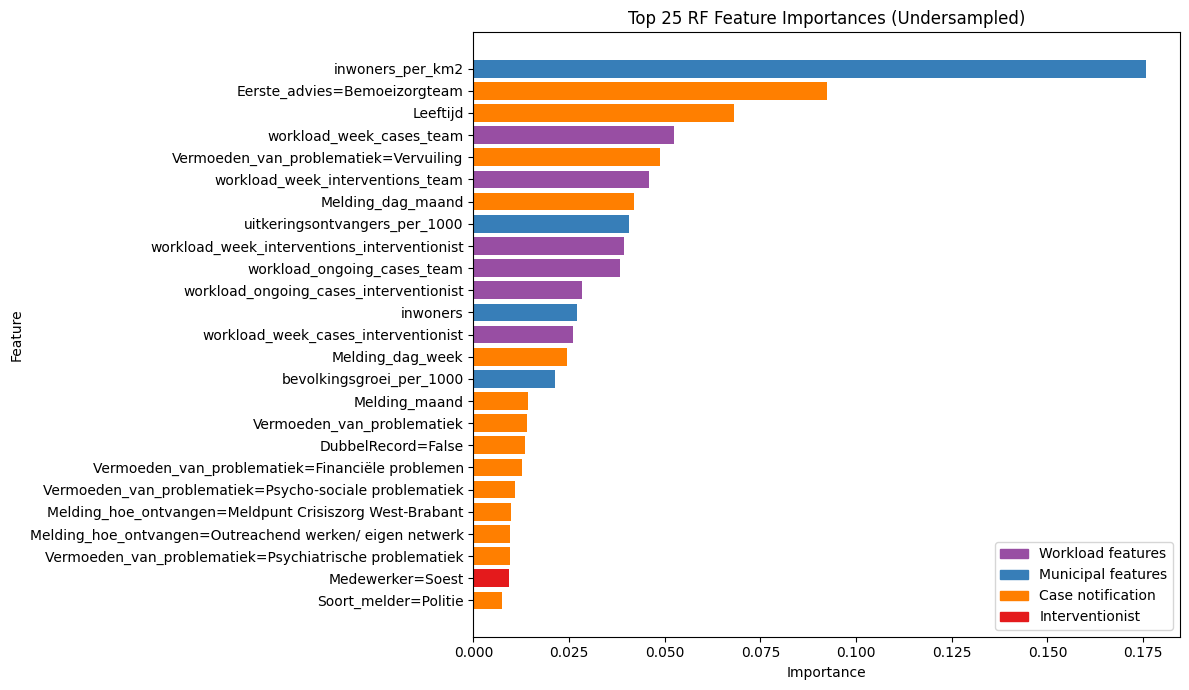

In [20]:
# Store feature importances
rf_estimator = randomforest_undersampled.estimators_[0]
rf_importances = pd.DataFrame(rf_estimator.feature_importances_, index=X_train_val_balanced_featurized.columns, columns=['importance']).sort_values('importance', ascending=False)

# Select the top 25 features
rf_importances_top25 = rf_importances.head(25)

# Apply the color map to your data
rf_importances_top25['color'] = [next((colors[group] for group, features in groups.items() if feature in features), 'gray') for feature in rf_importances_top25.index]

# Create custom patches for the legend
patches = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]

# Plot the feature importances
plt.figure(figsize=(12,7))
plt.barh(rf_importances_top25.index, rf_importances_top25['importance'], color=rf_importances_top25['color'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 RF Feature Importances (Undersampled)')
plt.gca().invert_yaxis()
plt.legend(handles=patches, loc='lower right')
plt.tight_layout()
plt.subplots_adjust(left=0.4)
plt.tight_layout()
plt.savefig('..\\visualizations\\overleaf_final\\rf_features_undersampled.png', transparent=True)
plt.show()

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
80/80 ━━━━━━━━━━━━━━━━

C:\Users\l.hanen\AppData\Local\Temp\2\ipykernel_15440\1607329498.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffnn_importances_top25['color'] = [next((colors[group] for group, features in groups.items() if feature in features), 'gray') for feature in ffnn_importances_top25['feature']]


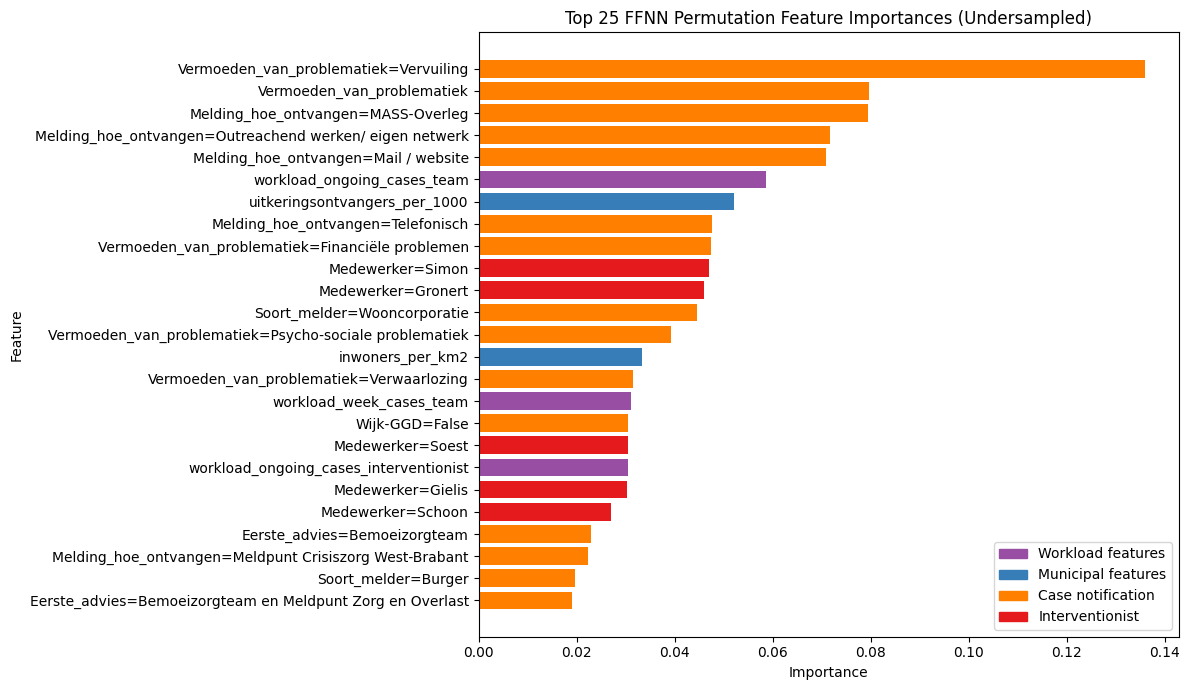

In [21]:
# Define a custom scoring function
def custom_score(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)  # Use negative mean squared error because scikit-learn's scoring functions follow the convention that higher score values are better than lower values

# Create a scorer object
scorer = make_scorer(custom_score)

# Compute permutation feature importances
result = permutation_importance(neuralnetwork_undersampled, X_train_val_balanced_featurized, y_train_val_balanced_log, n_repeats=10, random_state=42, scoring=scorer)

# Store feature importances in a DataFrame
ffnn_importances = pd.DataFrame({'feature': X_train_val_balanced_featurized.columns, 'importance': result.importances_mean}).sort_values('importance', ascending=False)

# Select the top 25 features
ffnn_importances_top25 = ffnn_importances.head(25)

# Apply the color map to your data
ffnn_importances_top25['color'] = [next((colors[group] for group, features in groups.items() if feature in features), 'gray') for feature in ffnn_importances_top25['feature']]

# Create custom patches for the legend
patches = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]

# Plot importances
plt.figure(figsize=(12,7))
plt.barh(ffnn_importances_top25['feature'], ffnn_importances_top25['importance'], color=ffnn_importances_top25['color'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 FFNN Permutation Feature Importances (Undersampled)')
plt.gca().invert_yaxis()
plt.legend(handles=patches, loc='lower right')
plt.tight_layout()
plt.subplots_adjust(left=0.4)
plt.tight_layout()
plt.savefig('..\\visualizations\\overleaf_final\\ffnn_features_undersampled.png', transparent=True)
plt.show()

#### 4.2 Regular

##### 4.2.1 Baselines

In [22]:
# Initialize lists to store the results
mean_test = []
median_test = []

# Calculate mean and median of the training set
mean_pred = y_train_val_log.mean()
median_pred = y_train_val_log.median()

# Print the mean and median predictions, after reversing the log scaling
print(f'Mean prediction: {np.expm1(mean_pred)}')
print(f'Median prediction: {np.expm1(median_pred)}')

# Create DataFrames filled with the mean and median for each prediction
y_pred_test_mean = pd.DataFrame([mean_pred]*len(y_test_log), columns=y_train_val_log.columns)
y_pred_test_median = pd.DataFrame([median_pred]*len(y_test_log), columns=y_train_val_log.columns)

# Calculate validation metrics for mean predictor
metrics_mean_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_mean['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_mean['Dagen_tot_laatst']), 2)
}
mean_test.append(metrics_mean_test)

# Calculate validation metrics for median predictor
metrics_median_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_median['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_median['Dagen_tot_laatst']), 2)
}
median_test.append(metrics_median_test)

# Convert the results to DataFrames for easier viewing
mean_test_regular = pd.DataFrame(mean_test, index=['Mean'])
median_test_regular = pd.DataFrame(median_test, index=['Median'])

Mean prediction: Dagen_tot_laatst    16.306552
No_interventions     2.223867
dtype: float64
Median prediction: Dagen_tot_laatst    16.0
No_interventions     2.0
dtype: float64


In [23]:
# Initialize list to store the results
ridge_test = []

# Fit model
ridge = Ridge(random_state=42)
ridge.fit(X_train_val_featurized, y_train_val_log)

# Get model predictions on test set
y_pred_test_ridge = ridge.predict(X_test_featurized)

# Inverse log() transform the predictions
y_pred_test_ridge = np.expm1(y_pred_test_ridge)

# Set all negative predictions to 0
y_pred_test_ridge = np.where(y_pred_test_ridge < 0, 0, y_pred_test_ridge)

# Iterate over each row of y_pred_val_ffnn and set both to 0  if one of them is 0
for i in range(len(y_pred_test_ridge)):
    if y_pred_test_ridge[i][1] == 0:
        y_pred_test_ridge[i] = [0, 0]

# Calculate validation metrics
y_pred_test_ridge_df = pd.DataFrame(y_pred_test_ridge, columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate metrics for each output separately and append to the results list
metrics_ridge_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_ridge_df['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_ridge_df['Dagen_tot_laatst']), 2)
}

# Convert the results to a DataFrame for easier viewing
ridge_test_regular = pd.DataFrame(metrics_ridge_test, index=['Ridge'])

##### 4.2.2 Models

In [24]:
# Predict test set
y_pred_test_rf_regular = randomforest_regular.predict(X_test_featurized)
y_pred_test_rf_regular = np.expm1(y_pred_test_rf_regular)
y_pred_test_rf_regular = np.where(y_pred_test_rf_regular < 0, 0, y_pred_test_rf_regular)
for i in range(len(y_pred_test_rf_regular)):
    if y_pred_test_rf_regular[i][1] == 0:
        y_pred_test_rf_regular[i] = [0, 0]
y_pred_test_rf_regular_df = pd.DataFrame(y_pred_test_rf_regular, columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate test metrics
metrics_rf_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_rf_regular_df['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_rf_regular_df['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_rf_regular_df['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_rf_regular_df['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_rf_regular_df['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_rf_regular_df['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_rf_regular_df['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_rf_regular_df['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_rf_regular_df['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_rf_regular_df['Dagen_tot_laatst']), 2)
}

# Store the results in a dataframe
rf_test_regular = pd.DataFrame(metrics_rf_test, index=['RF_best'])

In [25]:
# Predict test set
y_pred_test_ffnn_regular = neuralnetwork_regular.predict(X_test_featurized)
y_pred_test_ffnn_regular = np.expm1(y_pred_test_ffnn_regular)
y_pred_test_ffnn_regular = np.where(y_pred_test_ffnn_regular < 0, 0, y_pred_test_ffnn_regular)
for i in range(len(y_pred_test_ffnn_regular)):
    if y_pred_test_ffnn_regular[i][1] == 0:
        y_pred_test_ffnn_regular[i] = [0, 0]
y_pred_test_ffnn_regular_df = pd.DataFrame(y_pred_test_ffnn_regular, columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate test metrics
metrics_ffnn_test = {
    'mae_interventions': round(median_absolute_error(y_test['No_interventions'], y_pred_test_ffnn_regular_df['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_regular_df['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test['No_interventions'], y_pred_test_ffnn_regular_df['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_regular_df['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test['No_interventions'], y_pred_test_ffnn_regular_df['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_regular_df['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test['No_interventions'], y_pred_test_ffnn_regular_df['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_regular_df['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test['No_interventions'], y_pred_test_ffnn_regular_df['No_interventions']), 2),
    'r2_days': round(r2_score(y_test['Dagen_tot_laatst'], y_pred_test_ffnn_regular_df['Dagen_tot_laatst']), 2)
}

# Store the results in a dataframe
ffnn_test_regular = pd.DataFrame(metrics_ffnn_test, index=['FFNN_best'])

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [26]:
# Combine mean_test_undersampled, median_test_undersampled, ridge_test_undersampled, rf_test_undersampled and ffnn_test_undersampled
test_regular = pd.concat([mean_test_regular, median_test_regular, ridge_test_regular, rf_test_regular, ffnn_test_regular])
test_regular

,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
Mean,0.83,9.15,2.198262e+14,6.035550e+14,5.26,2095.36,0.26,3.22,-0.17,-0.42
Median,0.90,9.17,2.063109e+14,5.997717e+14,5.39,2096.25,0.28,3.23,-0.20,-0.42
Ridge,1.35,14.36,3.307220e+14,3.526722e+15,5.63,1436.60,0.34,1.59,-0.26,0.03
RF_best,0.99,12.84,2.361534e+14,2.861566e+15,4.24,1412.87,0.24,1.48,0.05,0.05
FFNN_best,0.80,10.17,2.127947e+14,2.135183e+15,4.07,1348.77,0.21,1.28,0.09,0.09


In [27]:
# Show improvement/deterioration
improvement_undersampling = round(((test_undersampled - test_regular) / test_regular * 100), 2)
improvement_undersampling

,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
Mean,-10.84,-1.86,7.42,5.94,-2.85,-0.40,-3.85,-3.42,-17.65,-2.38
Median,0.00,-1.20,0.00,3.93,0.00,-0.26,0.00,-2.17,-0.00,-2.38
Ridge,-17.78,-7.52,-11.66,-12.57,-16.70,-3.50,-17.65,-6.29,-80.77,100.00
RF_best,3.03,3.89,2.40,-4.56,0.00,-1.84,0.00,-0.68,0.00,20.00
FFNN_best,-5.00,-7.87,-13.44,-22.28,-8.11,2.27,-4.76,-2.34,88.89,-22.22


In [28]:
# Show improvement/deterioration
improvement_regular = round(((test_regular - test_undersampled) / test_undersampled * 100), 2)
improvement_regular

,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
Mean,12.16,1.89,-6.90,-5.60,2.94,0.40,4.00,3.54,21.43,2.44
Median,0.00,1.21,0.00,-3.78,0.00,0.26,0.00,2.22,-0.00,2.44
Ridge,21.62,8.13,13.20,14.37,20.04,3.63,21.43,6.71,420.00,-50.00
RF_best,-2.94,-3.75,-2.34,4.78,0.00,1.87,0.00,0.68,0.00,-16.67
FFNN_best,5.26,8.54,15.52,28.67,8.82,-2.22,5.00,2.40,-47.06,28.57


##### 4.2.3 Feature importance/SHAP summary

C:\Users\l.hanen\AppData\Local\Temp\2\ipykernel_15440\3185631319.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_importances_top25['color'] = [next((colors[group] for group, features in groups.items() if feature in features), 'gray') for feature in rf_importances_top25.index]


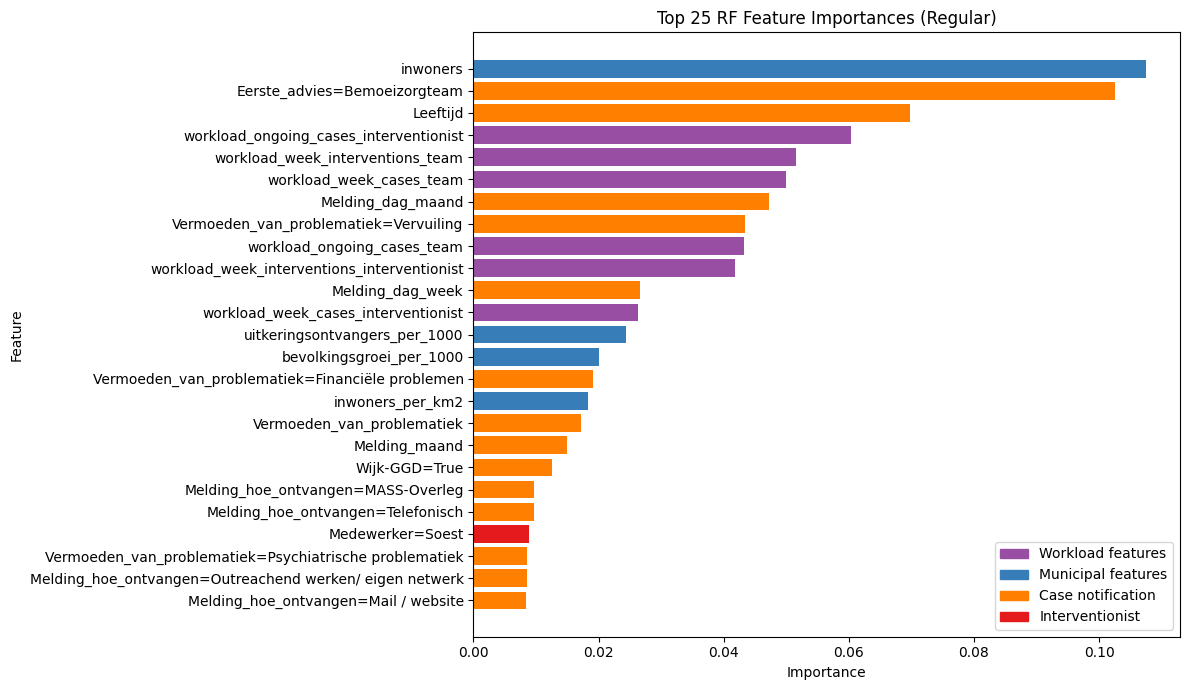

In [29]:
# Store feature importances
rf_estimator = randomforest_regular.estimators_[0]
rf_importances = pd.DataFrame(rf_estimator.feature_importances_, index=X_train_val_featurized.columns, columns=['importance']).sort_values('importance', ascending=False)

# Select the top 25 features
rf_importances_top25 = rf_importances.head(25)

# Apply the color map to your data
rf_importances_top25['color'] = [next((colors[group] for group, features in groups.items() if feature in features), 'gray') for feature in rf_importances_top25.index]

# Create custom patches for the legend
patches = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]

# Plot the feature importances
plt.figure(figsize=(12,7))
plt.barh(rf_importances_top25.index, rf_importances_top25['importance'], color=rf_importances_top25['color'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 RF Feature Importances (Regular)')
plt.gca().invert_yaxis()
plt.legend(handles=patches, loc='lower right')
plt.subplots_adjust(left=0.4)
plt.tight_layout()
plt.savefig('..\\visualizations\\overleaf_final\\rf_features_regular.png', transparent=True)
plt.show()

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
96/96 ━━━━━━━━━━

C:\Users\l.hanen\AppData\Local\Temp\2\ipykernel_15440\1072421735.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffnn_importances_top25['color'] = [next((colors[group] for group, features in groups.items() if feature in features), 'gray') for feature in ffnn_importances_top25['feature']]


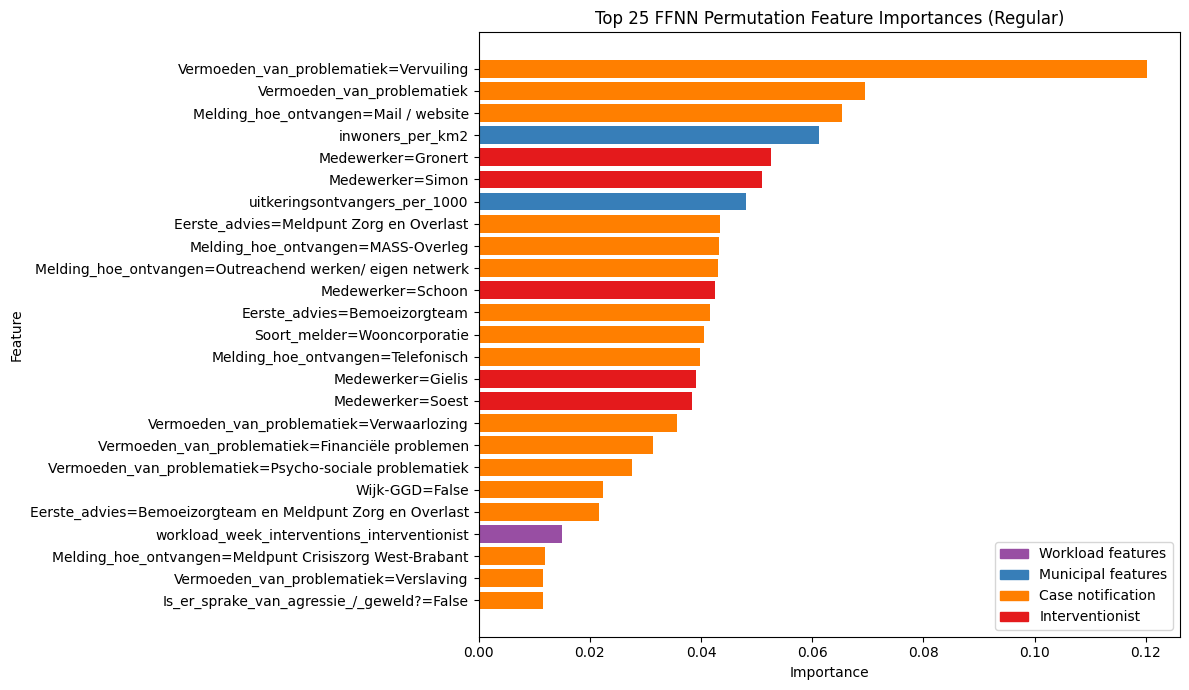

In [30]:
# Compute permutation feature importances
result = permutation_importance(neuralnetwork_regular, X_train_val_featurized, y_train_val_log, n_repeats=10, random_state=42, scoring=scorer)

# Store feature importances in a DataFrame
ffnn_importances = pd.DataFrame({'feature': X_train_val_featurized.columns, 'importance': result.importances_mean}).sort_values('importance', ascending=False)

# Select the top 25 features
ffnn_importances_top25 = ffnn_importances.head(25)

# Apply the color map to your data
ffnn_importances_top25['color'] = [next((colors[group] for group, features in groups.items() if feature in features), 'gray') for feature in ffnn_importances_top25['feature']]

# Create custom patches for the legend
patches = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]

# Plot importances
plt.figure(figsize=(12,7))
plt.barh(ffnn_importances_top25['feature'], ffnn_importances_top25['importance'], color=ffnn_importances_top25['color'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 FFNN Permutation Feature Importances (Regular)')
plt.gca().invert_yaxis()
plt.legend(handles=patches, loc='lower right')
plt.subplots_adjust(left=0.4)
plt.tight_layout()
plt.savefig('..\\visualizations\\overleaf_final\\ffnn_features_regular.png', transparent=True)
plt.show()

#### 4.3 Censored test set

Frome here on, we show the undersampling approach only because it yields better results.

In [31]:
# Predict censored test set
y_pred_test_censored_undersampled = neuralnetwork_undersampled.predict(X_test_censored_featurized)
y_pred_test_censored_undersampled = np.expm1(y_pred_test_censored_undersampled)
y_pred_test_censored_undersampled = np.where(y_pred_test_censored_undersampled < 0, 0, y_pred_test_censored_undersampled)
for i in range(len(y_pred_test_censored_undersampled)):
    if y_pred_test_censored_undersampled[i][1] == 0:
        y_pred_test_censored_undersampled[i] = [0, 0]
y_pred_test_censored_undersampled_df = pd.DataFrame(y_pred_test_censored_undersampled, columns=['Dagen_tot_laatst', 'No_interventions'], index=X_test_censored_featurized.index)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [32]:
# Import most up to date (16-05-2024) case information
y_test_censored = pd.read_pickle('..\\..\\Data\\Splits\\20240516_y_test_censored.pkl')

# Separate cases closed in the meantime and still censored cases
y_test_censored_closed = y_test_censored[y_test_censored['Closed'] == 1]
y_test_censored_still = y_test_censored[y_test_censored['Closed'] == 0]

# Print some of the characteristics
print(f'On May 2, 2024, we made predictions and set aside {len(y_pred_test_censored_undersampled_df)} censored cases')
print(f'On May 16, 2025, {len(y_pred_test_censored_undersampled_df)-len(y_test_censored)} of them were removed or disappeared from the dataset')
print(f'On May 16, 2025, {len(y_test_censored_still)} of them were still censored/not closed')
print(f'On May 16, 2025, {len(y_test_censored_closed)} of them were closed in the meantime')

# Select the rows from y_pred_test_censored_undersampled_df with the same indices as y_test_censored_closed
y_pred_test_censored_undersampled_closed = y_pred_test_censored_undersampled_df.loc[y_test_censored_closed.index]

# Calculate test metrics
metrics_ffnn_test_censored_closed = {
    'mae_interventions': round(median_absolute_error(y_test_censored_closed['No_interventions'], y_pred_test_censored_undersampled_closed['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_test_censored_closed['Dagen_tot_laatst'], y_pred_test_censored_undersampled_closed['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_test_censored_closed['No_interventions'], y_pred_test_censored_undersampled_closed['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_test_censored_closed['Dagen_tot_laatst'], y_pred_test_censored_undersampled_closed['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_test_censored_closed['No_interventions'], y_pred_test_censored_undersampled_closed['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_test_censored_closed['Dagen_tot_laatst'], y_pred_test_censored_undersampled_closed['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_test_censored_closed['No_interventions'], y_pred_test_censored_undersampled_closed['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_test_censored_closed['Dagen_tot_laatst'], y_pred_test_censored_undersampled_closed['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_test_censored_closed['No_interventions'], y_pred_test_censored_undersampled_closed['No_interventions']), 2),
    'r2_days': round(r2_score(y_test_censored_closed['Dagen_tot_laatst'], y_pred_test_censored_undersampled_closed['Dagen_tot_laatst']), 2)
}

# Store the results in a dataframe
ffnn_test_censored_closed = pd.DataFrame(metrics_ffnn_test_censored_closed, index=['FFNN_test_censored_closed'])
ffnn_test_censored_closed

On May 2, 2024, we made predictions and set aside 138 censored cases
On May 16, 2025, 5 of them were removed or disappeared from the dataset
On May 16, 2025, 119 of them were still censored/not closed
On May 16, 2025, 14 of them were closed in the meantime


,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
FFNN_test_censored_closed,0.65,32.65,0.76,2.36,9.26,5578.31,0.36,2.48,-0.11,-0.27


In [33]:
# Select the rows from y_pred_test_censored_undersampled_df with the same indices as y_test_censored_still
y_pred_test_censored_undersampled_still = y_pred_test_censored_undersampled_df.loc[y_test_censored_still.index]

# Store all rows where both columns of y_test_censored_still are greater than the corresponding rows in y_pred_test_censored_undersampled_still
exceeding_both = y_test_censored_still[(y_test_censored_still['No_interventions'] > y_pred_test_censored_undersampled_still['No_interventions']) &
                                       (y_test_censored_still['Dagen_tot_laatst'] > y_pred_test_censored_undersampled_still['Dagen_tot_laatst'])]

# Store all rows where only No_interventions of y_test_censored_still are greater than the corresponding rows in y_pred_test_censored_undersampled_still
exceeding_interventions = y_test_censored_still[(y_test_censored_still['No_interventions'] > y_pred_test_censored_undersampled_still['No_interventions']) &
                                                (y_test_censored_still['Dagen_tot_laatst'] <= y_pred_test_censored_undersampled_still['Dagen_tot_laatst'])]

# Store all rows where only Dagen_tot_laatst of y_test_censored_still are greater than the corresponding rows in y_pred_test_censored_undersampled_still
exceeding_days = y_test_censored_still[(y_test_censored_still['No_interventions'] <= y_pred_test_censored_undersampled_still['No_interventions']) &
                                       (y_test_censored_still['Dagen_tot_laatst'] > y_pred_test_censored_undersampled_still['Dagen_tot_laatst'])]

# Store all rows that do not exceed our predictions on either column
not_exceeding = y_test_censored_still[(y_test_censored_still['No_interventions'] <= y_pred_test_censored_undersampled_still['No_interventions']) &
                                      (y_test_censored_still['Dagen_tot_laatst'] <= y_pred_test_censored_undersampled_still['Dagen_tot_laatst'])]

# Print characteristics
print(f'{len(exceeding_both)} cases exceed our predictions on BOTH targets')
print(f'{len(exceeding_interventions)} cases exceed our predictions only on interventions')
print(f'{len(exceeding_days)} cases exceed our predictions only on days')
print(f'{len(not_exceeding)} cases do not exceed our predictions on either target (yet)')

# Check if exceeding_both, exceeding_interventions, exceeding_days and not_exceeding are all disjoint
assert len(exceeding_both) + len(exceeding_interventions) + len(exceeding_days) + len(not_exceeding) == len(y_test_censored_still)

46 cases exceed our predictions on BOTH targets
9 cases exceed our predictions only on interventions
15 cases exceed our predictions only on days
49 cases do not exceed our predictions on either target (yet)


#### 4.4 Error analysis

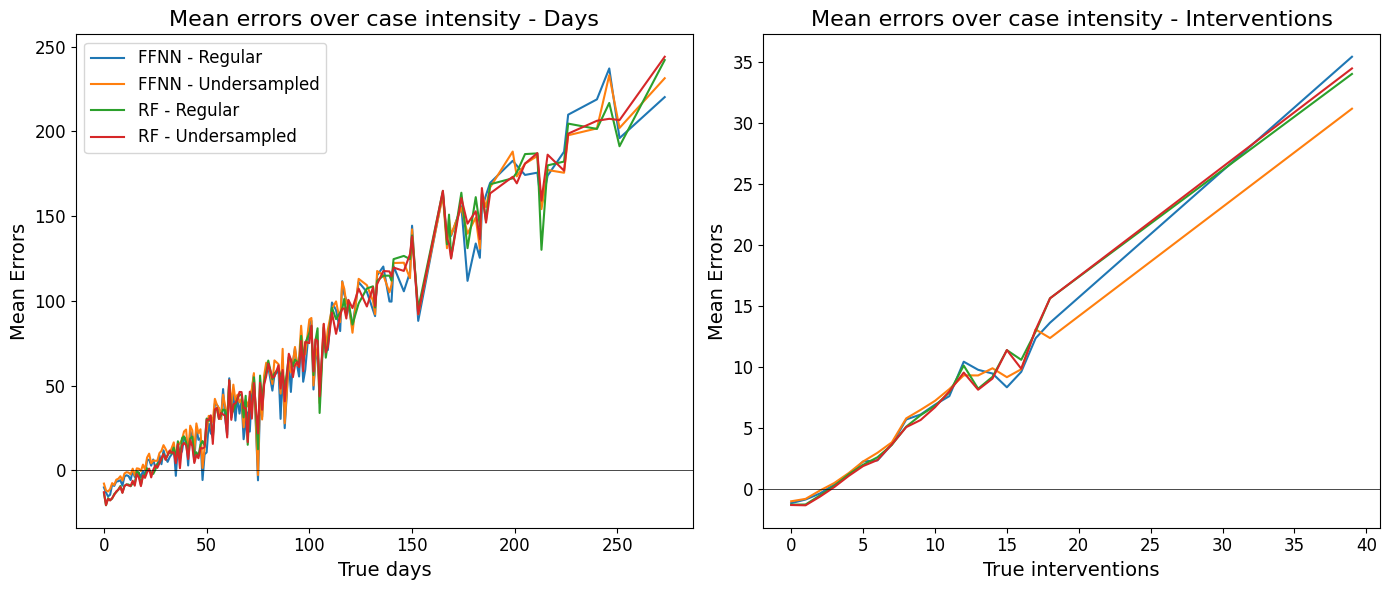

In [34]:
# Set indices of preds to those of true
y_pred_test_ffnn_regular_df = y_pred_test_ffnn_regular_df.set_index(y_test.index)
y_pred_test_ffnn_undersampled_df = y_pred_test_ffnn_undersampled_df.set_index(y_test.index)
y_pred_test_rf_regular_df = y_pred_test_rf_regular_df.set_index(y_test.index)
y_pred_test_rf_undersampled_df = y_pred_test_rf_undersampled_df.set_index(y_test.index)

# Calculate errors for days
errors_ffnn_regular_days = y_test['Dagen_tot_laatst'] - y_pred_test_ffnn_regular_df['Dagen_tot_laatst']
errors_ffnn_undersampled_days = y_test['Dagen_tot_laatst'] - y_pred_test_ffnn_undersampled_df['Dagen_tot_laatst']
errors_rf_regular_days = y_test['Dagen_tot_laatst'] - y_pred_test_rf_regular_df['Dagen_tot_laatst']
errors_rf_undersampled_days = y_test['Dagen_tot_laatst'] - y_pred_test_rf_undersampled_df['Dagen_tot_laatst']

# Create a DataFrame with true values and absolute errors for days
ffnn_regular_days = pd.DataFrame({'True': y_test['Dagen_tot_laatst'], 'Errors': errors_ffnn_regular_days})
ffnn_undersampled_days = pd.DataFrame({'True': y_test['Dagen_tot_laatst'], 'Errors': errors_ffnn_undersampled_days})
rf_regular_days = pd.DataFrame({'True': y_test['Dagen_tot_laatst'], 'Errors': errors_rf_regular_days})
rf_undersampled_days = pd.DataFrame({'True': y_test['Dagen_tot_laatst'], 'Errors': errors_rf_undersampled_days})

# Group by true values and calculate mean absolute error for days
mean_errors_ffnn_regular_days = ffnn_regular_days.groupby('True')['Errors'].mean()
mean_errors_ffnn_undersampled_days = ffnn_undersampled_days.groupby('True')['Errors'].mean()
mean_errors_rf_regular_days = rf_regular_days.groupby('True')['Errors'].mean()
mean_errors_rf_undersampled_days = rf_undersampled_days.groupby('True')['Errors'].mean()

# Calculate errors for interventions
errors_ffnn_regular_interventions = y_test['No_interventions'] - y_pred_test_ffnn_regular_df['No_interventions']
errors_ffnn_undersampled_interventions = y_test['No_interventions'] - y_pred_test_ffnn_undersampled_df['No_interventions']
errors_rf_regular_interventions = y_test['No_interventions'] - y_pred_test_rf_regular_df['No_interventions']
errors_rf_undersampled_interventions = y_test['No_interventions'] - y_pred_test_rf_undersampled_df['No_interventions']

# Create a DataFrame with true values and absolute errors for interventions
ffnn_regular_interventions = pd.DataFrame({'True': y_test['No_interventions'], 'Errors': errors_ffnn_regular_interventions})
ffnn_undersampled_interventions = pd.DataFrame({'True': y_test['No_interventions'], 'Errors': errors_ffnn_undersampled_interventions})
rf_regular_interventions = pd.DataFrame({'True': y_test['No_interventions'], 'Errors': errors_rf_regular_interventions})
rf_undersampled_interventions = pd.DataFrame({'True': y_test['No_interventions'], 'Errors': errors_rf_undersampled_interventions})

# Group by true values and calculate mean absolute error for interventions
mean_errors_ffnn_regular_interventions = ffnn_regular_interventions.groupby('True')['Errors'].mean()
mean_errors_ffnn_undersampled_interventions = ffnn_undersampled_interventions.groupby('True')['Errors'].mean()
mean_errors_rf_regular_interventions = rf_regular_interventions.groupby('True')['Errors'].mean()
mean_errors_rf_undersampled_interventions = rf_undersampled_interventions.groupby('True')['Errors'].mean()

# Create a new figure with 2 horizontal subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot mean absolute errors for the regular model for days
axs[0].plot(mean_errors_ffnn_regular_days.index, mean_errors_ffnn_regular_days.values, label='FFNN - Regular')
axs[0].plot(mean_errors_ffnn_undersampled_days.index, mean_errors_ffnn_undersampled_days.values, label='FFNN - Undersampled')
axs[0].plot(mean_errors_rf_regular_days.index, mean_errors_rf_regular_days.values, label='RF - Regular')
axs[0].plot(mean_errors_rf_undersampled_days.index, mean_errors_rf_undersampled_days.values, label='RF - Undersampled')

# Add a horizontal line at y=0
axs[0].axhline(0, color='black', linewidth=0.5)

# Add labels and title with increased font size
axs[0].set_xlabel('True days', fontsize=14)
axs[0].set_ylabel('Mean Errors', fontsize=14)
axs[0].set_title('Mean errors over case intensity - Days', fontsize=16)
axs[0].legend(fontsize=12)

# Increase the size of the axis ticks
axs[0].tick_params(axis='both', which='major', labelsize=12)

# Plot mean absolute errors for the regular model for interventions
axs[1].plot(mean_errors_ffnn_regular_interventions.index, mean_errors_ffnn_regular_interventions.values, label='FFNN - Regular')
axs[1].plot(mean_errors_ffnn_undersampled_interventions.index, mean_errors_ffnn_undersampled_interventions.values, label='FFNN - Undersampled')
axs[1].plot(mean_errors_rf_regular_interventions.index, mean_errors_rf_regular_interventions.values, label='RF - Regular')
axs[1].plot(mean_errors_rf_undersampled_interventions.index, mean_errors_rf_undersampled_interventions.values, label='RF - Undersampled')

# Add a horizontal line at y=0
axs[1].axhline(0, color='black', linewidth=0.5)

# Add labels and title with increased font size
axs[1].set_xlabel('True interventions', fontsize=14)
axs[1].set_ylabel('Mean Errors', fontsize=14)
axs[1].set_title('Mean errors over case intensity - Interventions', fontsize=16)

# Increase the size of the axis ticks
axs[1].tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.tight_layout()
plt.savefig('..\\visualizations\\overleaf_final\\error_analysis.png', transparent=True)
plt.show()

### 5. Out-of-sample experiment

#### 5.1 OoS predictions

##### 5.1.1 Baselines

In [35]:
# Initialize lists to store the results
mean_oos = []
median_oos = []

# Calculate mean and median of the training set
mean_pred = y_train_val_log.mean()
median_pred = y_train_val_log.median()

# Print the mean and median predictions, after reversing the log scaling
print(f'Mean prediction: {np.expm1(mean_pred)}')
print(f'Median prediction: {np.expm1(median_pred)}')

# Create DataFrames filled with the mean and median for each prediction
y_pred_oos_mean = pd.DataFrame([mean_pred]*len(y_oos), columns=y_train_val_log.columns)
y_pred_oos_median = pd.DataFrame([median_pred]*len(y_oos), columns=y_train_val_log.columns)

# Calculate validation metrics for mean predictor
metrics_mean_oos = {
    'mae_interventions': round(median_absolute_error(y_oos['No_interventions'], y_pred_oos_mean['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_oos['Dagen_tot_laatst'], y_pred_oos_mean['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_oos['No_interventions'], y_pred_oos_mean['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_oos['Dagen_tot_laatst'], y_pred_oos_mean['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_oos['No_interventions'], y_pred_oos_mean['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_oos['Dagen_tot_laatst'], y_pred_oos_mean['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_oos['No_interventions'], y_pred_oos_mean['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_oos['Dagen_tot_laatst'], y_pred_oos_mean['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_oos['No_interventions'], y_pred_oos_mean['No_interventions']), 2),
    'r2_days': round(r2_score(y_oos['Dagen_tot_laatst'], y_pred_oos_mean['Dagen_tot_laatst']), 2)
}
mean_oos.append(metrics_mean_oos)

# Calculate validation metrics for median predictor
metrics_median_oos = {
    'mae_interventions': round(median_absolute_error(y_oos['No_interventions'], y_pred_oos_median['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_oos['Dagen_tot_laatst'], y_pred_oos_median['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_oos['No_interventions'], y_pred_oos_median['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_oos['Dagen_tot_laatst'], y_pred_oos_median['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_oos['No_interventions'], y_pred_oos_median['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_oos['Dagen_tot_laatst'], y_pred_oos_median['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_oos['No_interventions'], y_pred_oos_median['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_oos['Dagen_tot_laatst'], y_pred_oos_median['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_oos['No_interventions'], y_pred_oos_median['No_interventions']), 2),
    'r2_days': round(r2_score(y_oos['Dagen_tot_laatst'], y_pred_oos_median['Dagen_tot_laatst']), 2)
}
median_oos.append(metrics_median_oos)

# Convert the results to DataFrames for easier viewing
mean_oos_undersampled = pd.DataFrame(mean_oos, index=['Mean'])
median_oos_undersampled = pd.DataFrame(median_oos, index=['Median'])

Mean prediction: Dagen_tot_laatst    16.306552
No_interventions     2.223867
dtype: float64
Median prediction: Dagen_tot_laatst    16.0
No_interventions     2.0
dtype: float64


In [36]:
# Initialize list to store the results
ridge_oos = []

# Fit model
ridge = Ridge(random_state=42)
ridge.fit(X_train_val_featurized, y_train_val_log)

# Get model predictions on test set
y_pred_oos_ridge = ridge.predict(X_oos_featurized)

# Inverse log() transform the predictions
y_pred_oos_ridge = np.expm1(y_pred_oos_ridge)

# Set all negative predictions to 0
y_pred_oos_ridge = np.where(y_pred_oos_ridge < 0, 0, y_pred_oos_ridge)

# Iterate over each row of y_pred_val_ffnn and set both to 0  if one of them is 0
for i in range(len(y_pred_oos_ridge)):
    if y_pred_oos_ridge[i][1] == 0:
        y_pred_oos_ridge[i] = [0, 0]

# Calculate validation metrics
y_pred_oos_ridge_df = pd.DataFrame(y_pred_oos_ridge, columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate metrics for each output separately and append to the results list
metrics_ridge_oos = {
    'mae_interventions': round(median_absolute_error(y_oos['No_interventions'], y_pred_oos_ridge_df['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_oos['Dagen_tot_laatst'], y_pred_oos_ridge_df['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_oos['No_interventions'], y_pred_oos_ridge_df['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_oos['Dagen_tot_laatst'], y_pred_oos_ridge_df['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_oos['No_interventions'], y_pred_oos_ridge_df['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_oos['Dagen_tot_laatst'], y_pred_oos_ridge_df['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_oos['No_interventions'], y_pred_oos_ridge_df['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_oos['Dagen_tot_laatst'], y_pred_oos_ridge_df['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_oos['No_interventions'], y_pred_oos_ridge_df['No_interventions']), 2),
    'r2_days': round(r2_score(y_oos['Dagen_tot_laatst'], y_pred_oos_ridge_df['Dagen_tot_laatst']), 2)
}

# Convert the results to a DataFrame for easier viewing
ridge_oos_undersampled = pd.DataFrame(metrics_ridge_oos, index=['Ridge'])

##### 5.1.2 Models

In [37]:
# Predict test set
y_pred_oos_rf_undersampled = randomforest_undersampled.predict(X_oos_featurized)
y_pred_oos_rf_undersampled = np.expm1(y_pred_oos_rf_undersampled)
y_pred_oos_rf_undersampled = np.where(y_pred_oos_rf_undersampled < 0, 0, y_pred_oos_rf_undersampled)
for i in range(len(y_pred_oos_rf_undersampled)):
    if y_pred_oos_rf_undersampled[i][1] == 0:
        y_pred_oos_rf_undersampled[i] = [0, 0]
y_pred_oos_rf_undersampled_df = pd.DataFrame(y_pred_oos_rf_undersampled, columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate test metrics
metrics_rf_oos = {
    'mae_interventions': round(median_absolute_error(y_oos['No_interventions'], y_pred_oos_rf_undersampled_df['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_oos['Dagen_tot_laatst'], y_pred_oos_rf_undersampled_df['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_oos['No_interventions'], y_pred_oos_rf_undersampled_df['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_oos['Dagen_tot_laatst'], y_pred_oos_rf_undersampled_df['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_oos['No_interventions'], y_pred_oos_rf_undersampled_df['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_oos['Dagen_tot_laatst'], y_pred_oos_rf_undersampled_df['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_oos['No_interventions'], y_pred_oos_rf_undersampled_df['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_oos['Dagen_tot_laatst'], y_pred_oos_rf_undersampled_df['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_oos['No_interventions'], y_pred_oos_rf_undersampled_df['No_interventions']), 2),
    'r2_days': round(r2_score(y_oos['Dagen_tot_laatst'], y_pred_oos_rf_undersampled_df['Dagen_tot_laatst']), 2)
}

# Store the results in a dataframe
rf_oos_undersampled = pd.DataFrame(metrics_rf_oos, index=['RF_best'])

In [38]:
# Predict test set
y_pred_oos_ffnn_undersampled = neuralnetwork_undersampled.predict(X_oos_featurized)
y_pred_oos_ffnn_undersampled = np.expm1(y_pred_oos_ffnn_undersampled)
y_pred_oos_ffnn_undersampled = np.where(y_pred_oos_ffnn_undersampled < 0, 0, y_pred_oos_ffnn_undersampled)
for i in range(len(y_pred_oos_ffnn_undersampled)):
    if y_pred_oos_ffnn_undersampled[i][1] == 0:
        y_pred_oos_ffnn_undersampled[i] = [0, 0]
y_pred_oos_ffnn_undersampled_df = pd.DataFrame(y_pred_oos_ffnn_undersampled, columns=['Dagen_tot_laatst', 'No_interventions'])

# Calculate test metrics
metrics_ffnn_oos = {
    'mae_interventions': round(median_absolute_error(y_oos['No_interventions'], y_pred_oos_ffnn_undersampled_df['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_oos['Dagen_tot_laatst'], y_pred_oos_ffnn_undersampled_df['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_oos['No_interventions'], y_pred_oos_ffnn_undersampled_df['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_oos['Dagen_tot_laatst'], y_pred_oos_ffnn_undersampled_df['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_oos['No_interventions'], y_pred_oos_ffnn_undersampled_df['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_oos['Dagen_tot_laatst'], y_pred_oos_ffnn_undersampled_df['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_oos['No_interventions'], y_pred_oos_ffnn_undersampled_df['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_oos['Dagen_tot_laatst'], y_pred_oos_ffnn_undersampled_df['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_oos['No_interventions'], y_pred_oos_ffnn_undersampled_df['No_interventions']), 2),
    'r2_days': round(r2_score(y_oos['Dagen_tot_laatst'], y_pred_oos_ffnn_undersampled_df['Dagen_tot_laatst']), 2)
}

# Store the results in a dataframe
ffnn_oos_undersampled = pd.DataFrame(metrics_ffnn_oos, index=['FFNN_best'])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [39]:
# Combine mean_ooos_undersampled, median_oos_undersampled, ridge_oos_undersampled, rf_oos_undersampled and ffnn_oos_undersampled
oos_undersampled = pd.concat([mean_oos_undersampled, median_oos_undersampled, ridge_oos_undersampled, rf_oos_undersampled, ffnn_oos_undersampled])
oos_undersampled

,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
Mean,0.83,6.15,5.316132e+14,1.294805e+15,5.97,1170.36,0.31,2.65,-0.13,-0.39
Median,0.90,6.17,4.989287e+14,1.286688e+15,6.09,1171.01,0.32,2.66,-0.16,-0.39
Ridge,0.80,9.98,7.036040e+14,6.092689e+15,5.16,833.62,0.29,1.60,0.02,0.01
RF_best,1.15,14.01,1.099559e+15,1.101762e+16,5.61,841.00,0.37,2.09,-0.06,0.00
FFNN_best,0.74,8.00,6.959157e+14,4.823756e+15,5.55,914.52,0.32,1.60,-0.05,-0.08


#### 5.2 Censored OoS set

In [40]:
# Predict censored oos set
y_pred_oos_censored_undersampled = neuralnetwork_undersampled.predict(X_oos_censored_featurized)
y_pred_oos_censored_undersampled = np.expm1(y_pred_oos_censored_undersampled)
y_pred_oos_censored_undersampled = np.where(y_pred_oos_censored_undersampled < 0, 0, y_pred_oos_censored_undersampled)
for i in range(len(y_pred_oos_censored_undersampled)):
    if y_pred_oos_censored_undersampled[i][1] == 0:
        y_pred_oos_censored_undersampled[i] = [0, 0]
y_pred_oos_censored_undersampled_df = pd.DataFrame(y_pred_oos_censored_undersampled, columns=['Dagen_tot_laatst', 'No_interventions'], index=X_oos_censored_featurized.index)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [41]:
# Import most up to date (16-05-2024) case information
y_oos_censored = pd.read_pickle('..\\..\\Data\\Splits\\20240516_y_oos_censored.pkl')

# Separate cases closed in the meantime and still censored cases
y_oos_censored_closed = y_oos_censored[y_oos_censored['Closed'] == 1]
y_oos_censored_still = y_oos_censored[y_oos_censored['Closed'] == 0]

# Print some of the characteristics
print(f'On May 2, 2024, we made predictions and set aside {len(y_pred_oos_censored_undersampled_df)} censored cases')
print(f'On May 16, 2025, {len(y_pred_oos_censored_undersampled_df)-len(y_oos_censored)} of them were removed or disappeared from the dataset')
print(f'On May 16, 2025, {len(y_oos_censored_still)} of them were still censored/not closed')
print(f'On May 16, 2025, {len(y_oos_censored_closed)} of them were closed in the meantime')

# Select the rows from y_pred_oos_censored_undersampled_df with the same indices as y_oos_censored_closed
y_pred_oos_censored_undersampled_closed = y_pred_oos_censored_undersampled_df.loc[y_oos_censored_closed.index]

# Calculate oos metrics
metrics_ffnn_oos_censored_closed = {
    'mae_interventions': round(median_absolute_error(y_oos_censored_closed['No_interventions'], y_pred_oos_censored_undersampled_closed['No_interventions']), 2),
    'mae_days': round(median_absolute_error(y_oos_censored_closed['Dagen_tot_laatst'], y_pred_oos_censored_undersampled_closed['Dagen_tot_laatst']), 2),
    'mape_interventions': round(mean_absolute_percentage_error(y_oos_censored_closed['No_interventions'], y_pred_oos_censored_undersampled_closed['No_interventions']), 2),
    'mape_days': round(mean_absolute_percentage_error(y_oos_censored_closed['Dagen_tot_laatst'], y_pred_oos_censored_undersampled_closed['Dagen_tot_laatst']), 2),
    'mse_interventions': round(mean_squared_error(y_oos_censored_closed['No_interventions'], y_pred_oos_censored_undersampled_closed['No_interventions']), 2),
    'mse_days': round(mean_squared_error(y_oos_censored_closed['Dagen_tot_laatst'], y_pred_oos_censored_undersampled_closed['Dagen_tot_laatst']), 2),
    'msle_interventions': round(mean_squared_log_error(y_oos_censored_closed['No_interventions'], y_pred_oos_censored_undersampled_closed['No_interventions']), 2),
    'msle_days': round(mean_squared_log_error(y_oos_censored_closed['Dagen_tot_laatst'], y_pred_oos_censored_undersampled_closed['Dagen_tot_laatst']), 2),
    'r2_interventions': round(r2_score(y_oos_censored_closed['No_interventions'], y_pred_oos_censored_undersampled_closed['No_interventions']), 2),
    'r2_days': round(r2_score(y_oos_censored_closed['Dagen_tot_laatst'], y_pred_oos_censored_undersampled_closed['Dagen_tot_laatst']), 2)
}

# Store the results in a dataframe
ffnn_oos_censored_closed = pd.DataFrame(metrics_ffnn_oos_censored_closed, index=['FFNN_oos_censored_closed'])
ffnn_oos_censored_closed

On May 2, 2024, we made predictions and set aside 123 censored cases
On May 16, 2025, 1 of them were removed or disappeared from the dataset
On May 16, 2025, 102 of them were still censored/not closed
On May 16, 2025, 20 of them were closed in the meantime


,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
FFNN_oos_censored_closed,0.77,11.45,0.52,0.52,13.75,995.8,0.44,0.94,-0.04,-0.08


In [42]:
# Select the rows from y_pred_oos_censored_undersampled_df with the same indices as y_oos_censored_still
y_pred_oos_censored_undersampled_still = y_pred_oos_censored_undersampled_df.loc[y_oos_censored_still.index]

# Store all rows where both columns of y_oos_censored_still are greater than the corresponding rows in y_pred_oos_censored_undersampled_still
exceeding_both = y_oos_censored_still[(y_oos_censored_still['No_interventions'] > y_pred_oos_censored_undersampled_still['No_interventions']) &
                                       (y_oos_censored_still['Dagen_tot_laatst'] > y_pred_oos_censored_undersampled_still['Dagen_tot_laatst'])]

# Store all rows where only No_interventions of y_oos_censored_still are greater than the corresponding rows in y_pred_oos_censored_undersampled_still
exceeding_interventions = y_oos_censored_still[(y_oos_censored_still['No_interventions'] > y_pred_oos_censored_undersampled_still['No_interventions']) &
                                                (y_oos_censored_still['Dagen_tot_laatst'] <= y_pred_oos_censored_undersampled_still['Dagen_tot_laatst'])]

# Store all rows where only Dagen_tot_laatst of y_oos_censored_still are greater than the corresponding rows in y_pred_oos_censored_undersampled_still
exceeding_days = y_oos_censored_still[(y_oos_censored_still['No_interventions'] <= y_pred_oos_censored_undersampled_still['No_interventions']) &
                                       (y_oos_censored_still['Dagen_tot_laatst'] > y_pred_oos_censored_undersampled_still['Dagen_tot_laatst'])]

# Store all rows that do not exceed our predictions on either column
not_exceeding = y_oos_censored_still[(y_oos_censored_still['No_interventions'] <= y_pred_oos_censored_undersampled_still['No_interventions']) &
                                      (y_oos_censored_still['Dagen_tot_laatst'] <= y_pred_oos_censored_undersampled_still['Dagen_tot_laatst'])]

# Print characteristics
print(f'{len(exceeding_both)} cases exceed our predictions on BOTH targets')
print(f'{len(exceeding_interventions)} cases exceed our predictions only on interventions')
print(f'{len(exceeding_days)} cases exceed our predictions only on days')
print(f'{len(not_exceeding)} cases do not exceed our predictions on either target (yet)')

# Check if exceeding_both, exceeding_interventions, exceeding_days and not_exceeding are all disjoint
assert len(exceeding_both) + len(exceeding_interventions) + len(exceeding_days) + len(not_exceeding) == len(y_oos_censored_still)

32 cases exceed our predictions on BOTH targets
5 cases exceed our predictions only on interventions
10 cases exceed our predictions only on days
55 cases do not exceed our predictions on either target (yet)
